In [51]:
%matplotlib inline
from __future__ import division
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import base64
import os
import pandas as pd
from Bio import motifs
import subprocess
import shutil
import cPickle as pickle
from Bio.motifs.jaspar.db import JASPAR5
from IPython.display import display, Image, HTML

from Bio import pairwise2
from Bio.pairwise2 import format_alignment 

specie_mapping = pd.read_table('http://jaspar.genereg.net/html/DOWNLOAD/database/TAX.txt', 
                               header=None, index_col=0,
                              names= ['ID','SpecieName'])

In [52]:
def job_connect():
    JASPAR_DB_HOST = 'vm5.cmmt.ubc.ca'
    JASPAR_DB_NAME = 'JASPAR_2016'
    return JASPAR5(host=JASPAR_DB_HOST, 
                   name=JASPAR_DB_NAME, 
                   user='jaspar_r', 
                   password='')

In [53]:
try:
    all_motifs_load = pickle.load(open('static/all_motifs.pickle','rb'))
except IOError:
    jdb =  job_connect()
    all_motifs = jdb.fetch_motifs()
    picklestring = pickle.dump(all_motifs, open('static/all_motifs.pickle','wb'))

In [54]:
def display_motifs(motifs=[]):
    for i in range(0,len(motifs)-1):
        m1 = motifs[i]
        m2 = motifs[i+1]
        specie1 = ('-').join(specie_mapping.loc[int(s), 'SpecieName'] for s in m1.species)
        name1 = m1.name
        specie2 = ('-').join(specie_mapping.loc[int(s), 'SpecieName'] for s in m2.species)
        name2 = m2.name
        logo1 = '{}-{}.png'.format(name1, specie1)
        logo2 = '{}-{}.png'.format(name2, specie2)
        m1.weblogo('static/{}'.format(logo1), logo_title=logo1[:-3])
        m2.weblogo('static/{}'.format(logo2), logo_title=logo2[:-3])        
        with open('static/{}'.format(logo1), "rb") as image_file:
            im1 = 'data:image/png;base64,' +\
            base64.b64encode(image_file.read())
        with open('static/{}'.format(logo2), "rb") as image_file:
            im2 = 'data:image/png;base64,' +\
            base64.b64encode(image_file.read())
    
        s = """<center><table>
        <tr>
        <td><img src="%s" style="width: 400px;"/></td>
        <td><img src="%s" style="width: 400px;"/></td>
        </tr></table></center>"""%(im1, im2)
        t=HTML(s)
        return display(t)

In [55]:
def write_motifs(in_motifs):
    for motif in in_motifs:
        specie = ('-').join(specie_mapping.loc[int(s), 'SpecieName'] for s in motif.species)
        name = motif.name
        fn = 'static/{}-{}.pfm'.format(name, specie.replace(' ','_'))
        out_fn = fn[:-3]+'meme'
        with open(fn, 'w') as f:
            f.write(motifs.write([motif], 'pfm'))
        subprocess.call(['jaspar2meme', '-pfm', 'static'], cwd=os.getcwd(), stdout=open(out_fn,'w'))
        os.remove(os.path.abspath(fn))

In [56]:
#ctcf_motifs = jdb.fetch_motifs_by_name('CTCF')
#display_motifs(ctcf_motifs)
#write_motifs(ctcf_motifs)

In [57]:
set_tf = set()
for motif_m in all_motifs_load:
    set_tf.add(motif_m.name)    

In [58]:
tf_wise_motifs = {k:[] for k in set_tf}
for tf in set_tf:
    species_tf = [m for m in all_motifs_load if m.name == tf]
    tf_wise_motifs[tf] += species_tf


## Maximum number of species belong to a certain TF

In [59]:
max(len(tf_wise_motifs[x]) for x in set_tf)

2

In [38]:
ctcf_motifs = tf_wise_motifs['CTCF']
ctcf_1 = ctcf_motifs[0]
ctcf_2 = ctcf_motifs[1]

In [39]:
m1 = (str(ctcf_1.degenerate_consensus))
m2 = (str(ctcf_2.degenerate_consensus))
print(m1)
print(m2)

YNRCCASYAGRKGGCRSYN
NCNMYAGRTGGCGCY


In [49]:
for a in pairwise2.align.localms('YNNCCASYAGGKGGCRSNN', 'CNNYAGRTGGCGC', 2, 1, -3, -3): 
    print(format_alignment(*a)) 

YNNCCASYAGGKGGCRSNN
    |||||||||||||
----CNNYAGRTGGCGC--
  Score=20



## Pearson Correlation Coefficient
\begin{align*}
\mathcal{A} &= \{A,C,T,G\}\\
PCC(X,Y) &= \frac{\sum_{a \in A} (X_a-\bar{X})(Y_b-\bar{Y})}{\sum_{a \in A} (X_a-\bar{X})^2 \sum_{a \in A}(Y_b-\bar{Y})}\\
\bar{X} &= \frac{1}{|\mathcal{A}|} \sum_{a\in A} X_a\\
\bar{Y} &= \frac{1}{|\mathcal{A}|} \sum_{a\in A} Y_a\\
\end{align*}


In [149]:
A = ['A', 'T', 'C', 'G']
import numpy as np
def calculate_pearson_corr(motif1,motif2, start=None):
    """
    Arguments
    ----------
    motif1: Bio.motifs
        motif instance of first motif
        
    motif2: Bio.motifs
        motif instance of seocnd
        
    start: int
        position of motif1 where alignment starts
        
    end: int
        position of motif1 where alignment ends
    Questions
    ---------
    This simply ignores the non-overlapping sequence of the motifs. I need
    to see what appraoches are taken
    """
    pwm1 = motif1.pwm
    pwm2 = motif2.pwm
    assert motif1.length >= motif2.length
    end = motif2.length+start
    #This step is mostly redundant
    xbar = [1/4*sum(pwm1[x][i] for x in A) for i in range(start,end)]
    ybar = [1/4*sum(pwm2[x][i] for x in A) for i in range(0,motif2.length)]
    
    
    sxy = np.array([sum((pwm1[x][i]-xbar[i])*(pwm2[x][i]-ybar[i]) for x in A) for i in range(0,motif2.length)])
    
    
    sxx = np.array([sum((pwm1[x][i]-xbar[i])**2 for x in A) for i in range(0,motif2.length)])
    syy = np.array([sum((pwm2[x][i]-ybar[i])**2 for x in A) for i in range(0,motif2.length)])
    
    pcc = sxy/(np.sqrt(sxx*syy))
    return pcc

In [150]:
pwm = ctcf_1.pwm
pwm['A'][0]+pwm['C'][0]+pwm['T'][0]+pwm['G'][0]

1.0

In [151]:
aln = pairwise2.align.localms('YNNCCASYAGGKGGCRSNN', 'CNNYAGRTGGCGC', 2, 1, -3, -3)

In [152]:
x=aln[0]

In [153]:
calculate_pearson_corr(ctcf_1, ctcf_2,4)

array([ 0.77698474,  0.56502891,  0.95824228,  0.76730586,  0.63086166,
        0.99913666,  0.53723189,  0.20218959,  0.02923645,  0.99997915,
        0.85489613,  0.07148298,  0.99899281,  0.03657037,  0.77535241])

,

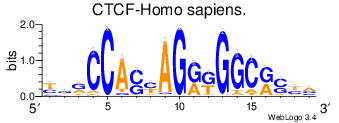
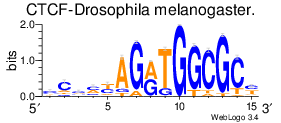

In [154]:
display_motifs([ctcf_1,ctcf_2])